In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')

## reading data from the csv file

In [ ]:
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)

# we are arranging the ratings according to time.
df.sort_values(by='date', inplace=True)
df.head()

In [5]:
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)

# we are arranging the ratings according to time.
df.sort_values(by='date', inplace=True)
df.head()

,movie,user,rating,date
58698779,10774,510180,3.0,1999-11-11
96212476,17064,510180,2.0,1999-11-11
6901473,1367,510180,5.0,1999-11-11
49973109,9003,510180,3.0,1999-11-11
20393918,3870,510180,2.0,1999-11-11


### Is there any entry that has Nan values...??

In [6]:
# it returns True for a row that has atleast one Nan value.
null_bool = df.isnull().any(axis = 1)
df[null_bool]

,movie,user,rating,date
95880696,16992,962,NaN,NaT
95963294,17002,51082,NaN,NaT


In [7]:
df.drop(df[null_bool].index, inplace=True)

In [8]:
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


### Let's try to find the duplicates if any...

In [9]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp )
print("There are {} duplicate rating entries in the data..".format(dups))

There are 1211 duplicate rating entries in the data..


In [10]:
# let's find what are the movies that has duplicate entries of user ratings....
df[dup_bool].movie.value_counts()

16969    762
16968    449
Name: movie, dtype: int64

__Removing those duplicate entries__  (inplace)

In [11]:
df.drop(df[dup_bool].index, inplace=True)

In [12]:
print("No of duplicate rows (movie, user, rating) entries :", sum(df.duplicated()))

No of duplicate rows (movie, user, rating) entries : 0


In [13]:
print("\nNo of ratings that we have, after removing nan rows and duplicates are :", df.shape[0])


No of ratings that we have, after removing nan rows and duplicates are : 100479045


## No. of Ratings, Users and Movies  

In [14]:
movies = df.movie.value_counts()
users = df.user.value_counts()
ratings = df.rating
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(users))
print("Total No of movies  :", len(movies))

Total data 
--------------------------------------------------

Total no of ratings : 100479045
Total No of Users   : 480189
Total No of movies  : 17770


## Train data

In [15]:
big_train_df = df.iloc[:int(df.shape[0]*0.80)]

In [16]:
big_train_df.shape

(80383236, 4)

In [17]:
big_train_df.head(2)

,movie,user,rating,date
58698779,10774,510180,3.0,1999-11-11
96212476,17064,510180,2.0,1999-11-11


In [18]:
movies = big_train_df.movie.value_counts()
users = big_train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",big_train_df.shape[0])
print("Total No of Users   :", len(users))
print("Total No of movies  :", len(movies))

Training data 
--------------------------------------------------

Total no of ratings : 80383236
Total No of Users   : 405024
Total No of movies  : 17423


# Creating sparse matrix for Train data

In [4]:
import os
from scipy import sparse
start = datetime.now()
if os.path.isfile('sample/train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('sample/train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((big_train_df.rating.values, (big_train_df.user.values,
                                               big_train_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')
 
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:03.086804


### Sparsity

In [5]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

In [6]:
print("Sparsity Of matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of matrix : 99.82927583214679 % 


## Test

In [ ]:
big_test_df = df.iloc[int(df.shape[0]*0.80) : ]
big_test_df.shape

In [26]:
big_test_df.head(2)

,movie,user,rating,date
52863848,9617,316390,2.0,2005-08-08
12989568,2462,605375,4.0,2005-08-08


In [27]:
movies = big_test_df.movie.value_counts()
users = big_test_df.user.value_counts()

print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",big_test_df.shape[0])
print("Total No of Users   :", len(users))
print("Total No of movies  :", len(movies))

Test data 
--------------------------------------------------

Total no of ratings : 20095809
Total No of Users   : 349327
Total No of movies  : 17757


#  Creating sparse matrix for Test data

In [ ]:
import os
from scipy import sparse
start = datetime.now()
if os.path.isfile('sample/test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('sample/test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((big_test_df.rating.values, (big_test_df.user.values,
                                               big_test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
 
print(datetime.now() - start)

### Sparsity

In [9]:
uss,mvv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

In [10]:
print("Sparsity Of matrix : {} % ".format(  (1-(elem/(uss*mvv))) * 100) )

Sparsity Of matrix : 99.95731855608713 % 


# Sampling Train and Test data 

In [4]:
import os
import random

## Train

In [6]:
import os
from scipy import sparse

start = datetime.now()
if os.path.isfile('sample/sample_train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz('sample/sample_train_sparse_matrix.npz')
    print("DONE..")
else: 
    row_ind, col_ind = train_sparse_matrix.nonzero()
    row_ind = np.unique(row_ind)
    col_ind = np.unique(col_ind)

    print("(users, movies) : ({} {})".format(len(row_ind), len(col_ind)))

    np.random.seed(15)
    sample_movies = np.random.choice(col_ind, 1000, replace=False)
    sample_users = np.random.choice(row_ind, 10000, replace=False)

    sample_train_sparse_matrix = train_sparse_matrix[sample_users, :][:,sample_movies]
    print('Done. It\'s shape is : (user, movie) : ',sample_train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/sample_train_sparse_matrix.npz", sample_train_sparse_matrix)
    print('Done..\n')


print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.135362


## Test

In [7]:
import os
from scipy import sparse

start = datetime.now()
if os.path.isfile('sample/sample_test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz('sample/sample_test_sparse_matrix.npz')
    print("DONE..")
else: 
    row_ind, col_ind = test_sparse_matrix.nonzero()
    row_ind = np.unique(row_ind)
    col_ind = np.unique(col_ind)

    print("(users, movies) : ({} {})".format(len(row_ind), len(col_ind)))

    np.random.seed(15)
    sample_movies = np.random.choice(col_ind, 500, replace=False)
    sample_users = np.random.choice(row_ind, 5000, replace=False)

    sample_test_sparse_matrix = test_sparse_matrix[sample_users, :][:,sample_movies]
    print('Done. It\'s shape is : (user, movie) : ',sample_test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/sample_test_sparse_matrix.npz", sample_test_sparse_matrix)
    print('Done..\n')


print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.014039


# Computing Average Ratings (from Train data)

In [7]:
averages = dict()

In [8]:
# Boolean matrix of ratings ( whether a user rated that movie or not)
is_rated = sample_train_sparse_matrix!=0

In [9]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
averages['global'] = global_average
averages

{'global': 3.6244573311785024}

### User averages

In [10]:
# get the user averages in dictionary (key: userid, value: avg rating)
#_____________________________________________________________________#

# ".A1" is for converting Column_Matrix to 1-D numpy array 
sum_of_ratings_per_user = sample_train_sparse_matrix.sum(axis=1).A1
# no of ratings that each user has given.
no_of_ratings_per_user = is_rated.sum(axis=1).A1

# creae a dictonary of users and their average ratigns..
average_user_ratings = { i : sum_of_ratings_per_user[i]/no_of_ratings_per_user[i]  
                                 for i in range(sample_train_sparse_matrix.shape[0]) 
                                    if no_of_ratings_per_user[i] !=0}

# add user averages to th eaverages dictionary
averages['user'] = average_user_ratings

# test it..
averages['user'][97]

4.5

### Movie Averages

In [11]:
# get the Movie Average ratings in dictionary (key: movieId, value: avg_rating)
#_____________________________________________________________________#

# sum of the ratings that a movie got by any user(who rated that movie..)
sum_of_ratings_per_movie = sample_train_sparse_matrix.sum(axis=0).A1
# no of ratings that a movie got.
no_of_ratings_per_movie = is_rated.sum(axis=0).A1

average_movie_ratings = {i : sum_of_ratings_per_movie[i]/ no_of_ratings_per_movie[i] 
                                for i in range(sample_train_sparse_matrix.shape[1])
                                    if no_of_ratings_per_movie[i]!=0 }

# add thie'per_movie' avg ratings to averages dictionary
averages['movie'] = average_movie_ratings

# test this dictionary
averages['movie'][30]

3.742857142857143

# Computing  Similarities (top 5 along with its ratings)

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
sample_train_sparse_matrix.count_nonzero()

126228

In [9]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [10]:
len((sample_train_users)), len(sample_train_movies), len(sample_train_ratings)

(126228, 126228, 126228)

In [11]:
sample_train_sparse_matrix.shape

(10000, 1000)

## Preparing Train data 

In [12]:
start = datetime.now()
if os.path.isfile('sample/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/reg_train.csv', mode='a') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(averages['user'][user])
            # Avg_movie rating
            row.append(averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%20000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00


In [13]:
sample_train_sparse_matrix.count_nonzero()

126228

## Preparing Test data

In [ ]:
test_sparse_matrix.count_nonzero()

In [15]:
sample_test_sparse_matrix.count_nonzero()

8208

In [16]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [17]:
len(np.unique(sample_test_users))

2449

In [18]:
start = datetime.now()
cold_start_count = 0
if os.path.isfile('sample/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/reg_test.csv', mode='a') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_test_sparse_matrix[user], sample_test_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_test_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings, end="--")

            except KeyError:
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                cold_start_count = cold_start_count + 1
                top_sim_users_ratings.extend([averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_test_sparse_matrix[:,movie].T, sample_test_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_test_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except KeyError:
                cold_start_count = cold_start_count + 1
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(averages['user'][user])
            except KeyError:
                row.append(averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(averages['movie'][movie])
            except KeyError:
                row.append(averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)
    print("\nNo. of cold start problems handled :", cold_start_count)

It is already created...


#### Percentage if Cold Start Cases handled

In [35]:
print("Cold Start Cases : {}%".format((cold_start_count/len(sample_test_ratings)) * 100 ))

Cold Start Cases : 19.46881091617934%


 ### Reading from the file to make a Train_dataframe

In [19]:
reg_train = pd.read_csv('sample/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                         'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                        'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.00,3.0
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.00,1.0
2,231,1,3.624457,3.0,3.0,4.0,4.0,4.0,2.0,5.0,5.0,5.0,4.0,3.761905,3.35,3.0
3,847,1,3.624457,3.0,4.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.090909,3.35,5.0
4,993,1,3.624457,3.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,5.0,3.0,3.172414,3.35,3.0


In [20]:
reg_train.shape

(126228, 16)

 ### Reading from the file to make a Test_dataframe

In [21]:
reg_test_df = pd.read_csv('sample/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                         'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                        'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.203390,2.0,3.0
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.000000,2.0,5.0
2,214,0,3.624457,3.0,4.0,4.0,2.0,4.0,5.00000,4.00000,5.00000,3.00000,5.00000,3.500000,2.0,3.0
3,283,0,3.624457,3.0,3.0,5.0,4.0,4.0,5.00000,5.00000,5.00000,5.00000,2.00000,4.133333,2.0,5.0


----------------------------------------------------------------------------------------------------
---

### Some Utility Functions for the model evaluation..** 

In [22]:
# to show how large or how small are the errors...
def print_error_dists(abs_errors):
    t0 = sum( abs_errors > 0 )
    t1 = sum( abs_errors > 1 )
    t2 = sum( abs_errors > 2 )
    t3 = sum( abs_errors > 3 )
    t4 = sum( abs_errors > 4 )
    
    print('No. of predicted ratings with error between 0 and 1(inclusive) :', t0-t1)
    print('No. of predicted ratings with error between 1 and 2(inclusive) :', t1-t2)
    print('No. of predicted ratings with error between 2 and 3(inclusive) :', t2-t3)
    print('No. of predicted ratings with error between 3 and 4(inclusive) :', t3-t4)
    print('No. of predicted ratings with error > 4 :', t4)

In [23]:
# to get rmse and mape for XGboost..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

----------------------------------------------------------------------------------------------------
---

### Some Global dictionary that stores rmse and mape for all the models....

- It stores the metrics in a dictionary of dictionaries

> __keys__ : model names(string)

> __value__: dict(__key__ : metric, __value__ : value )

In [24]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

----------------------------------------------------------------------------------------------------
---

Install xgboost in windows : https://www.youtube.com/watch?v=k51sX_ApQYU 

In [25]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

## 1. First XGBoost with default parameters..

In [30]:
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)

x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

start = datetime.now()

first_xgb.fit(x_train, y_train, eval_metric = 'rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=13, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [31]:
print(datetime.now() - start)

0:00:00.970650


In [32]:
start =datetime.now()
y_train_pred = first_xgb.predict(x_train)
print(datetime.now()-start)

0:00:00.071585


In [33]:
rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)

In [34]:
rmse_train, mape_train

(0.8473548013960125, 25.039259953928468)

In [35]:
print_error_dists(abs_errors=np.abs(y_train.values - y_train_pred))

No. of predicted ratings with error between 0 and 1(inclusive) : 98337
No. of predicted ratings with error between 1 and 2(inclusive) : 24755
No. of predicted ratings with error between 2 and 3(inclusive) : 2923
No. of predicted ratings with error between 3 and 4(inclusive) : 213
No. of predicted ratings with error > 4 : 0


#### Store the errors values in our global dictionary...

In [36]:
###################################################
models_evaluation_train['first_xgb'] = {'rmse':rmse_train, 'mape':mape_train}
models_evaluation_train['first_xgb']['predictions'] = y_train_pred

models_evaluation_train['first_xgb']

{'mape': 25.039259953928468,
 'predictions': array([2.3490567, 1.7247627, 3.4073272, ..., 3.038171 , 3.0399516,
        3.8002818], dtype=float32),
 'rmse': 0.8473548013960125}

<IPython.core.display.Javascript object>


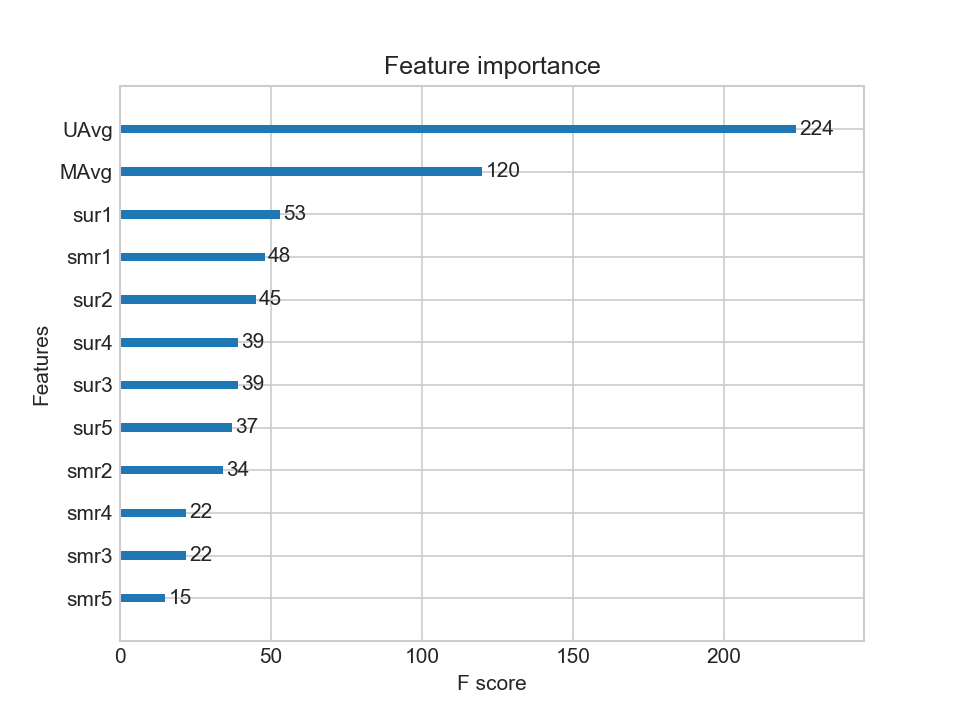

In [37]:
xgb.plot_importance(first_xgb)
plt.show()

## For Test Data

In [38]:
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

y_test_pred = first_xgb.predict(x_test)
rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
rmse_test, mape_test

(1.190164934503154, 35.03456000202348)

In [39]:
print_error_dists(np.abs(y_test.values-y_test_pred))

No. of predicted ratings with error between 0 and 1(inclusive) : 4905
No. of predicted ratings with error between 1 and 2(inclusive) : 2612
No. of predicted ratings with error between 2 and 3(inclusive) : 602
No. of predicted ratings with error between 3 and 4(inclusive) : 89
No. of predicted ratings with error > 4 : 0


#### Storing these error metrics to our global dictionary.. 

In [40]:
models_evaluation_test['first_xgb'] = {'rmse': rmse_test, 'mape':mape_test}
models_evaluation_test['first_xgb']['predictions'] = y_test_pred

models_evaluation_test['first_xgb']

{'mape': 35.03456000202348,
 'predictions': array([3.854013 , 2.3819778, 3.0049725, ..., 3.4059603, 3.237263 ,
        3.0150583], dtype=float32),
 'rmse': 1.190164934503154}

<IPython.core.display.Javascript object>


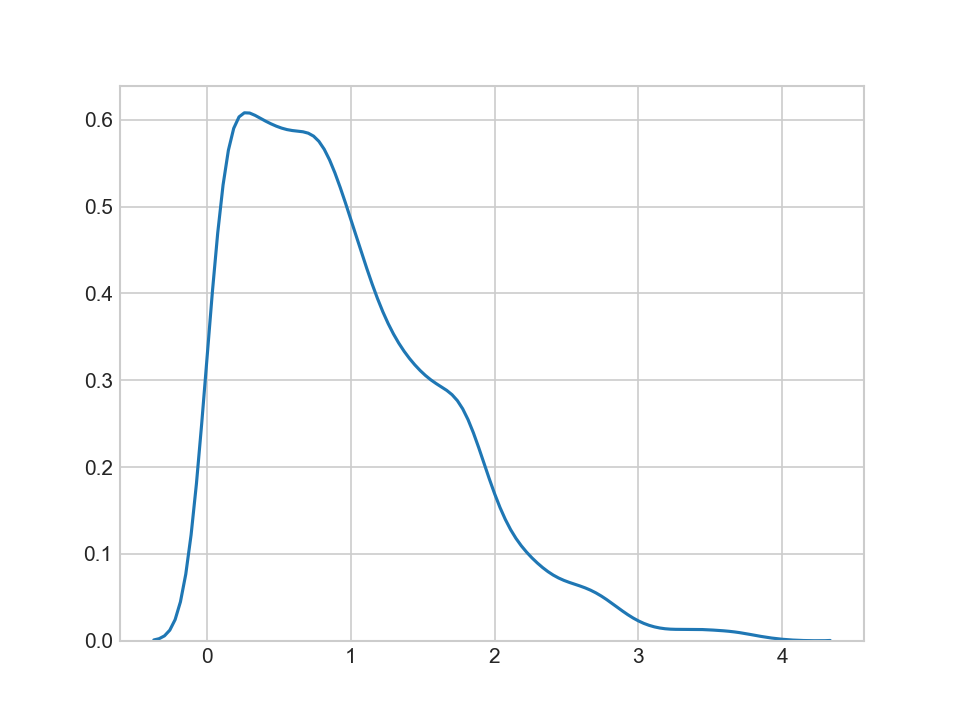

In [41]:
sns.distplot(np.abs( (y_test.values-y_test_pred)), hist=False)
plt.show()

-----------------------------------------------------------------------------------------------------
---
 

-----------------------------------------------------------------------------------------------------
---
 

In [42]:
import random
import numpy as np

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

## 1.2. Surprise -  CustomBaseLineModel 
    - with normal baseline model, we can't  count the number of cold start problems

In [28]:
from surprise import Reader, Dataset, BaselineOnly

- #### Predicted_rating : ( baseline prediction )

>$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $

- ####  Optimization function ( Least Squares Problem )

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$

- #### Preparing TrainData for this baseline model from surprise

In [29]:
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.00,3.0
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.00,1.0
2,231,1,3.624457,3.0,3.0,4.0,4.0,4.0,2.0,5.0,5.0,5.0,4.0,3.761905,3.35,3.0
3,847,1,3.624457,3.0,4.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.090909,3.35,5.0
4,993,1,3.624457,3.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,5.0,3.0,3.172414,3.35,3.0


In [30]:
reg_train.shape

(126228, 16)

In [31]:
reg_train[['user','movie','rating']].head()

,user,movie,rating
0,1590,0,3.0
1,1907,0,1.0
2,231,1,3.0
3,847,1,5.0
4,993,1,3.0


In [32]:
reader = Reader(rating_scale=(1,5))

In [33]:
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

In [34]:
# build the trainset from traindata
trainset = train_data.build_full_trainset()

### Baseline Model

In [35]:
class BaseLineAlgo(BaselineOnly):

    def __init__(self, sim_options={}, bsl_options={}):

        BaselineOnly.__init__(self, bsl_options=bsl_options)

    def fit(self, trainset):
        self.trainset = trainset
        BaselineOnly.fit(self, trainset)
        return self

    def estimate(self, u, i):
        details = {'cold_start':False}
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            details = {'cold_start':True}
        
        return BaselineOnly.estimate(self, u, i), details

In [36]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
my_bsl_algo = BaseLineAlgo(bsl_options=bsl_options)

In [37]:
my_bsl_algo.fit(trainset)

Estimating biases using sgd...


In [38]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

#############################################

def get_errors(predictions, include_cold_start = True, print_them=False):
    
    actual, pred = get_ratings(predictions)

    rmse = np.sqrt(np.mean( [(actual[i]-pred[i])**2  for i in range(len(actual))] ))
    mape = np.mean([ np.abs(actual[i]-pred[i])/actual[i] for i in range(len(actual)) ])

    if print_them:
        print("\nRMSE : {}\n\nMAPE : {}".format(rmse, mape*100))
    return rmse, mape*100

### evaluating Training data

In [39]:
bsl_train_preds = my_bsl_algo.test(trainset.build_testset())

In [40]:
bsl_train_preds[0]

Prediction(uid=1590, iid=0, r_ui=3.0, est=3.809650263762233, details={'cold_start': False, 'was_impossible': False})

In [41]:
my_bsl_train_rmse, my_bsl_train_mape = get_errors(bsl_train_preds, print_them=True)


RMSE : 0.9312622541249634

MAPE : 28.756547341945467


In [43]:
_, my_bsl_train_preds = get_ratings(bsl_train_preds)
my_bsl_train_preds

array([3.80965026, 3.19968029, 3.792209  , ..., 3.69131461, 3.93049387,
       3.91066456])

In [44]:
# Just store these error metrics in our models_evaluation datastructure
#########################################################################
models_evaluation_train['bsl_algo'] = {'rmse':my_bsl_train_rmse, 'mape':my_bsl_train_mape}
models_evaluation_train['bsl_algo']['predictions'] = my_bsl_train_preds

models_evaluation_train['bsl_algo']

{'mape': 28.756547341945467,
 'predictions': array([3.80965026, 3.19968029, 3.792209  , ..., 3.69131461, 3.93049387,
        3.91066456]),
 'rmse': 0.9312622541249634}

### Evaluating Test data

In [45]:
reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.203390,2.0,3.0
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.000000,2.0,5.0
2,214,0,3.624457,3.0,4.0,4.0,2.0,4.0,5.00000,4.00000,5.00000,3.00000,5.00000,3.500000,2.0,3.0
3,283,0,3.624457,3.0,3.0,5.0,4.0,4.0,5.00000,5.00000,5.00000,5.00000,2.00000,4.133333,2.0,5.0
4,297,0,3.624457,3.0,3.0,3.0,3.0,5.0,5.00000,3.00000,4.00000,5.00000,5.00000,4.333333,2.0,3.0


In [46]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))

In [47]:
test_preds = my_bsl_algo.test(testset)

In [48]:
test_preds[0]

Prediction(uid=118, iid=0, r_ui=3.0, est=3.948776296894135, details={'cold_start': False, 'was_impossible': False})

In [52]:
my_bsl_test_rmse, my_bsl_test_mape = get_errors(test_preds, print_them=True)


RMSE : 1.1674790109548865

MAPE : 35.805018461619866


In [53]:
#### Store these error metrics in our model_evaluations dict 
##############################################################################
models_evaluation_test['bsl_algo'] = {'rmse':my_bsl_test_rmse, 'mape':my_bsl_test_mape}

_, my_bsl_test_preds = get_ratings(test_preds)
models_evaluation_test['bsl_algo']['predictions'] = my_bsl_test_preds

models_evaluation_test['bsl_algo']

{'mape': 35.805018461619866,
 'predictions': array([3.9487763 , 3.54248358, 3.56137288, ..., 3.5184957 , 3.5188059 ,
        3.51197286]),
 'rmse': 1.1674790109548865}

## 1.3  XGBoost with Baseline Predictor

In [82]:
# previously....
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0


In [83]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0,3.80965
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0,3.19968


### 1.3.1 train XGBoost with this additional baseline feature

In [84]:
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

xgb_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
xgb_bsl.fit(x_train, y_train,eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=10, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### 1.3.2 Evaluating with train data...

In [85]:
start = datetime.now()
xgb_bsl_train_preds = xgb_bsl.predict(x_train)
print(datetime.now()-start)

0:00:00.065016


In [86]:
rmse, mape = get_error_metrics(y_true = y_train, y_pred = xgb_bsl_train_preds)
rmse, mape

(0.8473682995786805, 25.044914451887806)

In [87]:
print_error_dists(abs_errors=np.abs(y_train.values - xgb_bsl_train_preds))

No. of predicted ratings with error between 0 and 1(inclusive) : 98336
No. of predicted ratings with error between 1 and 2(inclusive) : 24744
No. of predicted ratings with error between 2 and 3(inclusive) : 2932
No. of predicted ratings with error between 3 and 4(inclusive) : 216
No. of predicted ratings with error > 4 : 0


In [88]:
#- Storing the metrics 
############################################
models_evaluation_train['xgb_bsl'] = {'rmse':rmse, 'mape':mape}
models_evaluation_train['xgb_bsl']['predictions'] = xgb_bsl_train_preds

models_evaluation_train['xgb_bsl']

{'mape': 25.044914451887806,
 'predictions': array([2.372274 , 1.7693403, 3.4035742, ..., 3.0373535, 3.0171025,
        3.8241556], dtype=float32),
 'rmse': 0.8473682995786805}

<IPython.core.display.Javascript object>


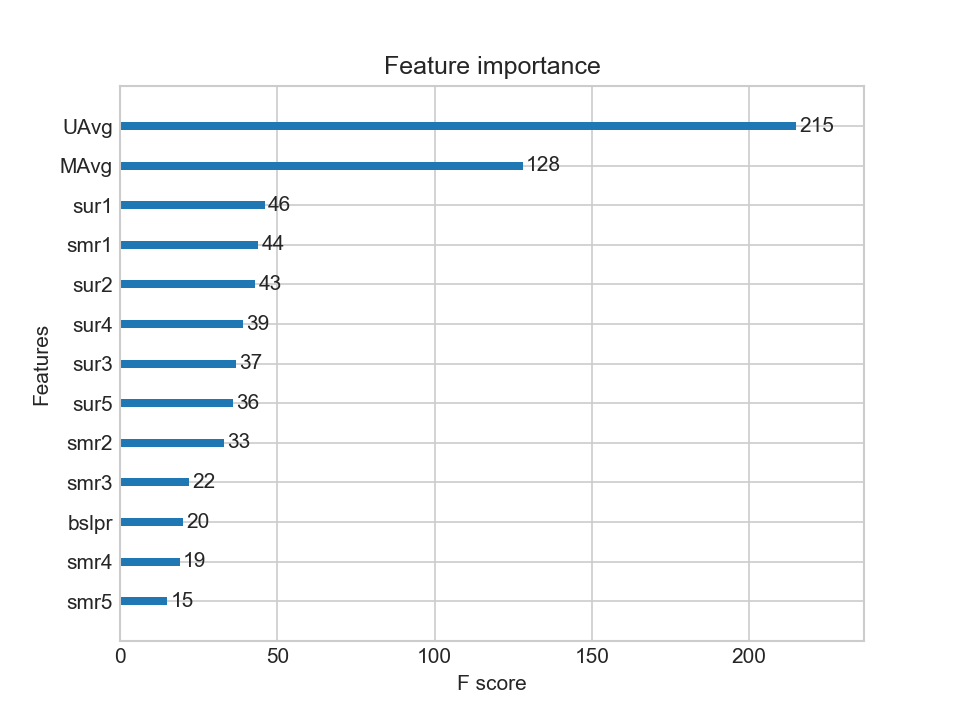

In [89]:
xgb.plot_importance(xgb_bsl)
plt.show()

 - Observations :
 

### 1.3.3 Evaluating new XGB with Traindata

In [90]:
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0


In [91]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0,3.948776
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0,3.542484


In [92]:
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

xgb_bsl_test_preds = xgb_bsl.predict(x_test)
rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=xgb_bsl_test_preds)
rmse_test, mape_test

(1.1896540970709255, 35.05026182158571)

In [93]:
# __ Storing these metrics to the dictionary__
#########################################################
models_evaluation_test['xgb_bsl'] = {'rmse': rmse_test, 'mape': mape_test}
models_evaluation_test['xgb_bsl']['predictions'] = xgb_bsl_test_preds

models_evaluation_test['xgb_bsl']

{'mape': 35.05026182158571,
 'predictions': array([3.8989341, 2.40227  , 3.0303586, ..., 3.402841 , 3.2198586,
        3.0186212], dtype=float32),
 'rmse': 1.1896540970709255}

In [94]:
print_error_dists(np.abs(y_test.values-xgb_bsl_test_preds))

No. of predicted ratings with error between 0 and 1(inclusive) : 4906
No. of predicted ratings with error between 1 and 2(inclusive) : 2616
No. of predicted ratings with error between 2 and 3(inclusive) : 596
No. of predicted ratings with error between 3 and 4(inclusive) : 90
No. of predicted ratings with error > 4 : 0


<IPython.core.display.Javascript object>


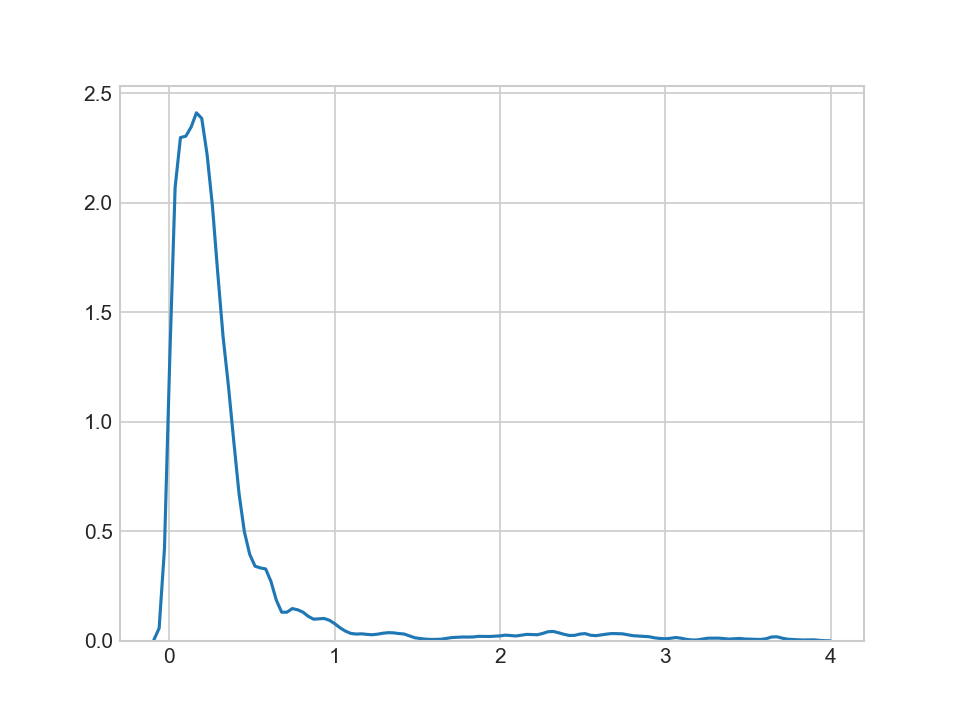

In [95]:
sns.distplot(np.abs(y_test.values - models_evaluation_test['xgb_bsl']['predictions']) / y_test.values, hist=False) 
plt.show()

In [264]:
print('\nTEST METRICS :')
print('-'*30)

print('First_xgb :({}, {})'.format(models_evaluation_test['first_xgb']['rmse'], models_evaluation_test['first_xgb']['mape']))
print('\nxgb_bsl :({}, {})'.format(models_evaluation_test['xgb_bsl']['rmse'], models_evaluation_test['xgb_bsl']['mape']))


TEST METRICS :
------------------------------
First_xgb :(1.1896540970709255, 35.05026182158571)

xgb_bsl :(1.1896540970709255, 35.05026182158571)


> Seems, there is no improvement at all with adding just the baseline_predictions to the model.. 

# 2. KNN with BaseLineModel

- __predicted Rating__ : ( ___ based on User-User similarity ___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
        - Computation of the correlation coefficient is based only on the common user support.
        - similarities based on a greater user support are more reliable ie., Users who has more number of common movie ratings are considered as more similar than users who has few no of movies  in common which are rated.
        - \begin{align}\begin{aligned}\text{pearson_baseline_shrunk_sim}(u, v) &= \frac{|I_{uv}| - 1}{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}\end{aligned}\end{align}
            - $\pmb{|I_{uv}|}$ - No of common movies between users(u and v)
            - __shrinkage__ - kind of hyperparameter. The defalut value suggested is ___100___
                - __0__ : There is no shrinkage at all ( It is normal pearson correlation coefficient ) 
            - $ \pmb {\hat \rho_uv}$ - Pearson Correlation Coefficient ( between users )
                - \begin{align} \text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{
    \sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui}) \cdot (r_{vi} -
    b_{vi})} {\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui})^2}
    \cdot \sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  b_{vi})^2}} \end{align}


 ------------ or 
 --

- __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  ___Notations follows same as above (user user based predicted rating ) ___

- We can do both and blend them ( see if we can better results when combined ) 

## 2.1 KNN with User User similarities 

In [54]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 

bsl_options = {'method': 'sgd'} # we keep other parameters like regularization parameter and learning_rate as default values.

In [55]:
from surprise import KNNBaseline

In [56]:
knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

## train the model with the trainset..
start = datetime.now()
knn_bsl_u.fit(trainset = trainset)
print(datetime.now() - start)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
0:00:33.755748


- __Evaluating it with TrainData__

In [57]:
start = datetime.now()
knn_bsl_u_train_preds = knn_bsl_u.test(trainset.build_testset())
print(datetime.now() - start)

0:01:16.299466


In [58]:
# get the error metrics (rmse and mape) for this train set 
knn_bsl_u_train_rmse,knn_bsl_u_train_mape = get_errors(knn_bsl_u_train_preds, print_them=True)


RMSE : 0.3417970858238777

MAPE : 9.193187599095861


In [60]:
# store them in our dictionary of all the models
###################################################################
models_evaluation_train['knn_bsl_u'] = {'rmse': knn_bsl_u_train_rmse,
                                      'mape': knn_bsl_u_train_mape}

_, knn_bsl_u_train_pred_ratings = get_ratings(knn_bsl_u_train_preds)
models_evaluation_train['knn_bsl_u']['predictions'] = knn_bsl_u_train_pred_ratings

models_evaluation_train['knn_bsl_u']

{'mape': 9.193187599095861,
 'predictions': array([3.        , 4.04954764, 3.98491025, ..., 5.        , 5.        ,
        4.        ]),
 'rmse': 0.3417970858238777}

- __Evaluating it with TestData__

In [61]:
# predict the ratings for the test data......
start = datetime.now()
knn_bsl_u_test_preds = knn_bsl_u.test(testset)
print(datetime.now() - start)

0:00:00.707114


In [62]:
knn_bsl_u_test_preds[0]

Prediction(uid=118, iid=0, r_ui=3.0, est=1.86135189886117, details={'actual_k': 1, 'was_impossible': False})

In [63]:
# get the predicted ratings
knn_bsl_u_test_actual_ratings, knn_bsl_u_test_pred_ratings = get_ratings(knn_bsl_u_test_preds)
# get rmse and mape for the test predictions
knn_bsl_u_test_rmse, knn_bsl_u_test_mape = get_errors(knn_bsl_u_test_preds, print_them=True)


RMSE : 1.3237746757149595

MAPE : 38.31024860443015


In [64]:
# store them in our models dictionary....
models_evaluation_test['knn_bsl_u'] = {'rmse': knn_bsl_u_test_rmse, 
                                       'mape': knn_bsl_u_test_mape}

models_evaluation_test['knn_bsl_u']['predictions'] = knn_bsl_u_test_pred_ratings

models_evaluation_test['knn_bsl_u']

{'mape': 38.31024860443015,
 'predictions': array([1.8613519 , 3.23967081, 3.34715901, ..., 3.3186867 , 3.32594915,
        3.29430802]),
 'rmse': 1.3237746757149595}

In [65]:
print_error_dists(np.abs(knn_bsl_u_test_actual_ratings-knn_bsl_u_test_pred_ratings))

No. of predicted ratings with error between 0 and 1(inclusive) : 4228
No. of predicted ratings with error between 1 and 2(inclusive) : 2951
No. of predicted ratings with error between 2 and 3(inclusive) : 882
No. of predicted ratings with error between 3 and 4(inclusive) : 134
No. of predicted ratings with error > 4 : 0


In [298]:
# sns.distplot(np.abs((knn_bsl_u_test_actual_ratings-knn_bsl_u_test_pred_ratings)/knn_bsl_u_test_actual_ratings), hist=False)
# plt.show()

## 2.2 KNN with Item Item similarities 

In [66]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 

bsl_options = {'method': 'sgd'} # we keep other parameters like regularization parameter and learning_rate as default values.

In [67]:
knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

## train the model with the trainset..
start = datetime.now()
knn_bsl_m.fit(trainset = trainset)
print(datetime.now() - start)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
0:00:01.442108


- __Evaluating it with TrainData__

In [68]:
start = datetime.now()
knn_bsl_m_train_preds = knn_bsl_m.test(trainset.build_testset())
print(datetime.now() - start)

0:00:08.359292


In [69]:
# get the error metrics (rmse and mape) for this train set 
knn_bsl_m_train_rmse,knn_bsl_m_train_mape = get_errors(knn_bsl_m_train_preds, print_them=True)


RMSE : 0.3417565257994054

MAPE : 8.832096148214427


In [70]:
# store them in our dictionary of all the models
###################################################################
models_evaluation_train['knn_bsl_m'] = {'rmse': knn_bsl_m_train_rmse,
                                      'mape': knn_bsl_m_train_mape}

_, knn_bsl_m_train_pred_ratings = get_ratings(knn_bsl_m_train_preds)
models_evaluation_train['knn_bsl_m']['predictions'] = knn_bsl_m_train_pred_ratings

models_evaluation_train['knn_bsl_m']

{'mape': 8.832096148214427,
 'predictions': array([3.05531754, 4.19358254, 3.97011677, ..., 5.        , 5.        ,
        4.        ]),
 'rmse': 0.3417565257994054}

- __Evaluating it with TestData__

In [71]:
# predict the ratings for the test data......
start = datetime.now()
knn_bsl_m_test_preds = knn_bsl_m.test(testset)
print(datetime.now() - start)

0:00:00.218581


In [72]:
knn_bsl_m_test_preds[0]

Prediction(uid=118, iid=0, r_ui=3.0, est=3.71241675632085, details={'actual_k': 8, 'was_impossible': False})

In [73]:
# get the predicted ratings
knn_bsl_m_test_actual_ratings, knn_bsl_m_test_pred_ratings = get_ratings(knn_bsl_m_test_preds)
# get rmse and mape for the test predictions
knn_bsl_m_test_rmse, knn_bsl_m_test_mape = get_errors(knn_bsl_m_test_preds, print_them=True)


RMSE : 1.330457797347872

MAPE : 38.381203718832154


In [74]:
# store them in our models dictionary....
models_evaluation_test['knn_bsl_m'] = {'rmse': knn_bsl_m_test_rmse, 
                                       'mape': knn_bsl_m_test_mape}

models_evaluation_test['knn_bsl_m']['predictions'] = knn_bsl_m_test_pred_ratings

models_evaluation_test['knn_bsl_m']

{'mape': 38.381203718832154,
 'predictions': array([3.71241676, 3.23967081, 3.34715901, ..., 3.3186867 , 3.60948706,
        3.29430802]),
 'rmse': 1.330457797347872}

In [75]:
print_error_dists(np.abs(knn_bsl_m_test_actual_ratings-knn_bsl_m_test_pred_ratings))

No. of predicted ratings with error between 0 and 1(inclusive) : 4335
No. of predicted ratings with error between 1 and 2(inclusive) : 2841
No. of predicted ratings with error between 2 and 3(inclusive) : 811
No. of predicted ratings with error between 3 and 4(inclusive) : 185
No. of predicted ratings with error > 4 : 0


In [117]:
# sns.distplot(np.abs((knn_bsl_m_test_actual_ratings-knn_bsl_m_test_pred_ratings)/knn_bsl_m_test_actual_ratings), hist=False)
# plt.show()

## 2.3 XGBoost with both KNNs(U_U and M_M sims) 

### 2.3.1 Preparing Train data

In [118]:
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0,3.80965
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0,3.19968


In [119]:
# delete that bslpr (baseline predictor). Since we have knn_baseline that has baselinepredictor.. 
# it will be a redundant feature after adding knn model otputs..
reg_train.drop('bslpr', axis=1, inplace=True)

# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0,3.000000,3.055318
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0,4.049548,4.193583


### 2.3.2 Preparing Test data 

In [122]:
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0,3.948776
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0,3.542484


In [123]:
# removing bslpr and add Knn predictors..
reg_test_df.drop('bslpr', axis=1, inplace=True)

reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0,1.861352,3.712417
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0,3.239671,3.239671


### 2.3.3a Running the XGBoost

In [124]:
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)

In [125]:
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

In [143]:
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0,3.000000,3.055318
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0,4.049548,4.193583


In [126]:
start = datetime.now()
xgb_knn_bsl.fit(x_train, y_train)
print(datetime.now()- start)

0:00:01.279076


<IPython.core.display.Javascript object>


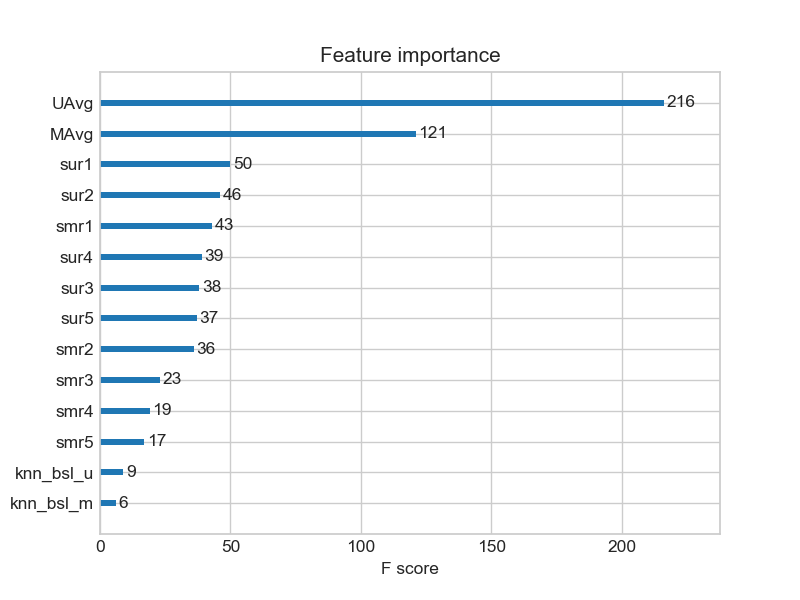

In [127]:
xgb.plot_importance(xgb_knn_bsl)
plt.show()

 #### 2.3.3.1 Evaluating with Train Data

In [128]:
start = datetime.now()
xgb_knn_bsl_train_preds = xgb_knn_bsl.predict(x_train)
print(datetime.now()- start)

0:00:00.067015


In [129]:
# find the error metrics and store them in dictionary..
xgb_knn_bsl_train_rmse, xgb_knn_bsl_train_mape = get_error_metrics(y_true = y_train.values, y_pred = xgb_knn_bsl_train_preds)

In [130]:
print_error_dists(np.abs(y_train.values -  xgb_knn_bsl_train_preds))

No. of predicted ratings with error between 0 and 1(inclusive) : 98332
No. of predicted ratings with error between 1 and 2(inclusive) : 24764
No. of predicted ratings with error between 2 and 3(inclusive) : 2919
No. of predicted ratings with error between 3 and 4(inclusive) : 213
No. of predicted ratings with error > 4 : 0


<IPython.core.display.Javascript object>


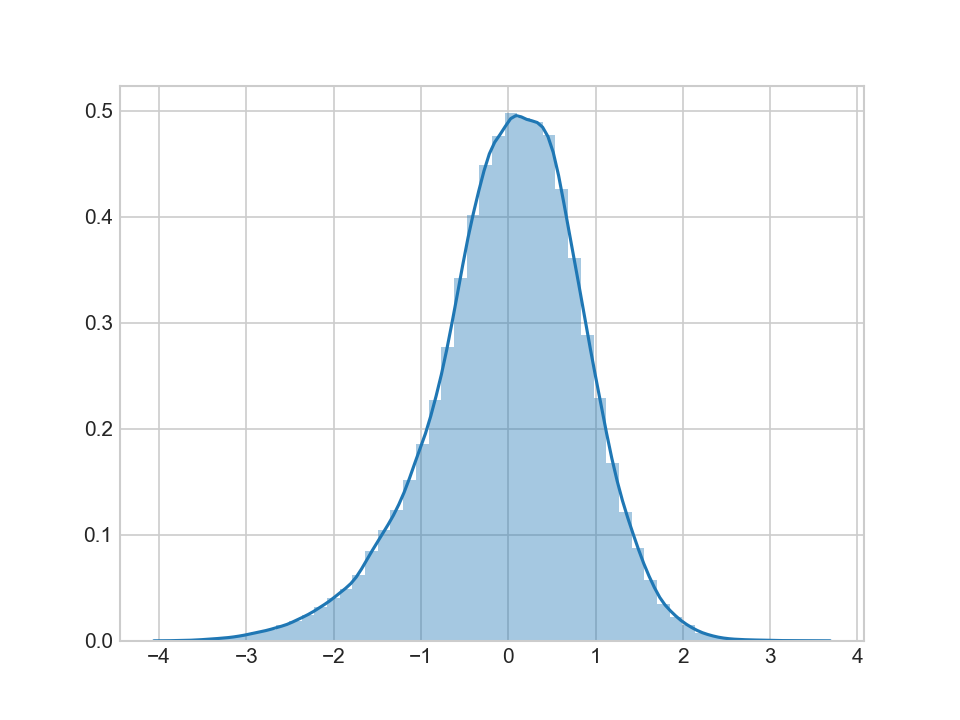

In [374]:
sns.distplot(y_train.values -  xgb_knn_bsl_train_preds)
plt.show()

In [132]:
# adding it's metrics to models dictionary 
#####################################################################
models_evaluation_train['xgb_knn_bsl'] = {'rmse' : xgb_knn_bsl_train_rmse,
                                          'mape' : xgb_knn_bsl_train_mape}
models_evaluation_train['xgb_knn_bsl']['predictions'] = xgb_knn_bsl_train_preds


models_evaluation_train['xgb_knn_bsl']

{'mape': 25.038882568411687,
 'predictions': array([2.3577995, 1.6805531, 3.39988  , ..., 3.042383 , 3.044038 ,
        3.8013272], dtype=float32),
 'rmse': 0.847306683109147}

 #### 2.3.3.2 Evaluating with Test Data

In [133]:
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0,1.861352,3.712417
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0,3.239671,3.239671


In [134]:
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

In [147]:
# get the predicted ratings for this test data
start = datetime.now()
xgb_knn_bsl_test_predictions = xgb_knn_bsl.predict(x_test)
print(datetime.now() - start)

0:00:00.010974


In [149]:
print_error_dists(np.abs(y_test.values - xgb_knn_bsl_test_predictions))

No. of predicted ratings with error between 0 and 1(inclusive) : 4887
No. of predicted ratings with error between 1 and 2(inclusive) : 2629
No. of predicted ratings with error between 2 and 3(inclusive) : 602
No. of predicted ratings with error between 3 and 4(inclusive) : 90
No. of predicted ratings with error > 4 : 0


<IPython.core.display.Javascript object>


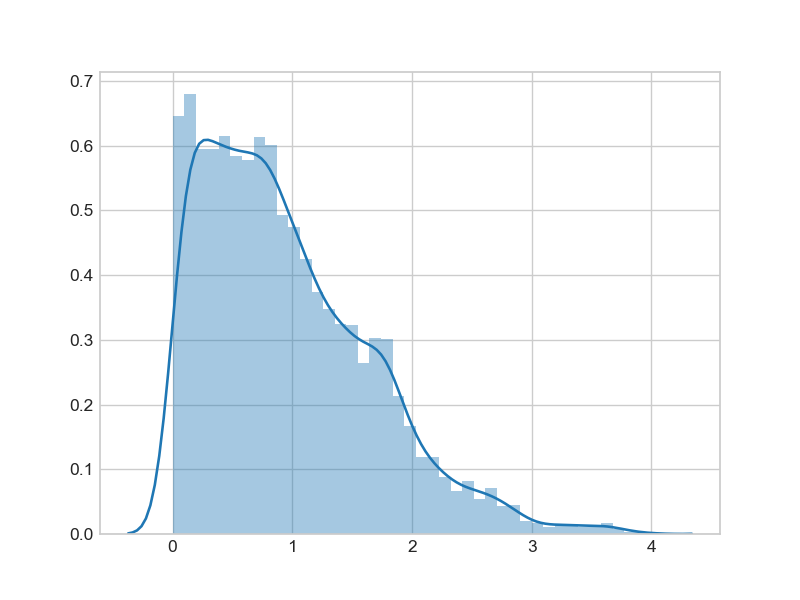

In [150]:
sns.distplot(np.abs(y_test.values-xgb_knn_bsl_test_predictions))
plt.show()

In [152]:
xgb_knn_bsl_test_rmse, xgb_knn_bsl_test_mape = get_error_metrics(y_test.values, xgb_knn_bsl_test_predictions) 

In [153]:
# store them
################################
models_evaluation_test['xgb_knn_bsl'] = {'rmse' : xgb_knn_bsl_test_rmse,
                                         'mape' : xgb_knn_bsl_test_mape}
models_evaluation_test['xgb_knn_bsl']['predictions'] = xgb_knn_bsl_test_predictions

models_evaluation_test['xgb_knn_bsl']

{'mape': 35.03356075494067,
 'predictions': array([3.8228877, 2.3294072, 2.9366271, ..., 3.4046302, 3.2192435,
        3.0204113], dtype=float32),
 'rmse': 1.1908479889747143}

### 2.3.3b Running the XGBoost ( with just two (UU and MM) nearest Neighbour predictors

In [154]:
# preparing train data
x_train = reg_train[['knn_bsl_u','knn_bsl_m']]
y_train = reg_train['rating']

# preparing test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m']]
y_test = reg_test_df['rating']

In [155]:
xgb_knn_bsl_mu = xgb.XGBRegressor(n_jobs=10, random_state=15)

In [156]:
xgb_knn_bsl_mu.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=10, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

<IPython.core.display.Javascript object>


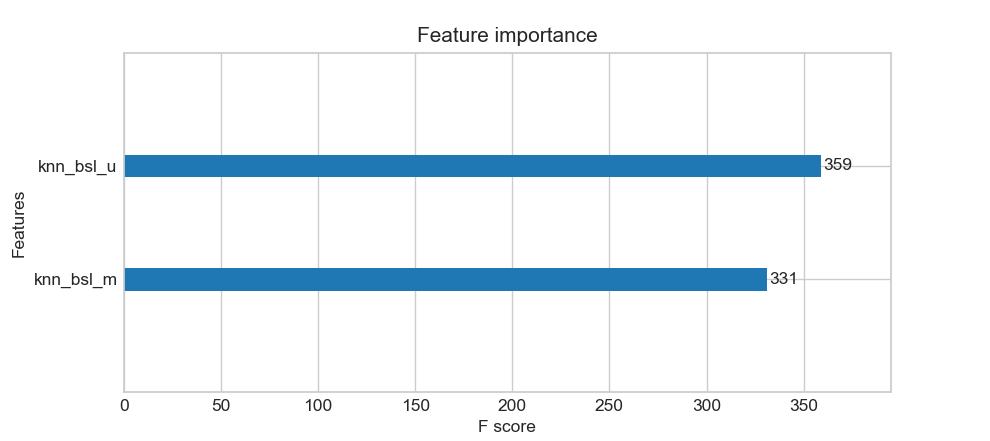

In [157]:
xgb.plot_importance(xgb_knn_bsl_mu)
plt.show()

- __Evaluating the model with the train data__

In [159]:
xgb_knn_bsl_mu_train_preds = xgb_knn_bsl_mu.predict(x_train)

# get the errors (rmse and mape)
xgb_knn_bsl_mu_train_rmse, xgb_knn_bsl_mu_train_mape = get_error_metrics(y_true=y_train.values, 
                                                                        y_pred = xgb_knn_bsl_mu_train_preds)

In [160]:
print_error_dists(np.abs(y_train.values - xgb_knn_bsl_mu_train_preds))

No. of predicted ratings with error between 0 and 1(inclusive) : 79059
No. of predicted ratings with error between 1 and 2(inclusive) : 41402
No. of predicted ratings with error between 2 and 3(inclusive) : 5767
No. of predicted ratings with error between 3 and 4(inclusive) : 0
No. of predicted ratings with error > 4 : 0


<IPython.core.display.Javascript object>


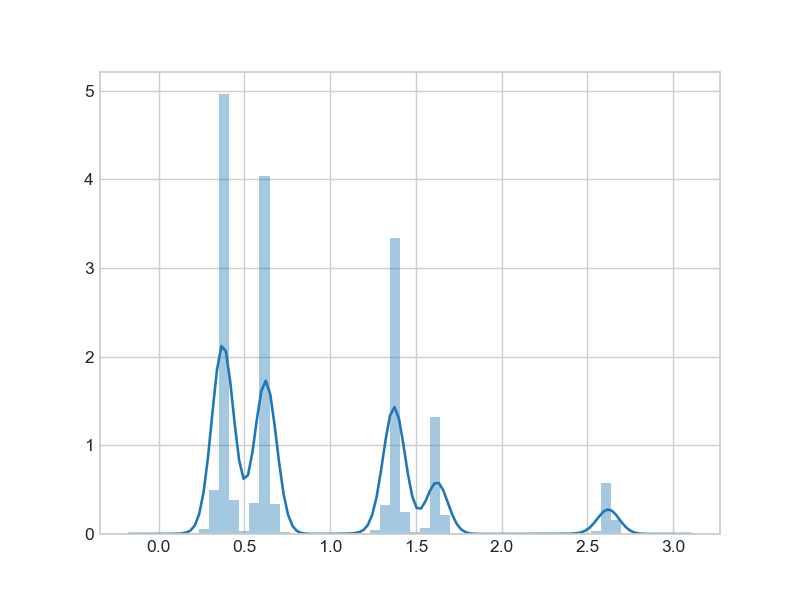

In [167]:
sns.distplot(np.abs(y_train.values - xgb_knn_bsl_mu_train_preds))
plt.show()

In [168]:
# store them in models dictionary..
models_evaluation_train['xgb_knn_bsl_mu'] = {'rmse' : xgb_knn_bsl_mu_train_rmse,
                                             'mape' : xgb_knn_bsl_mu_train_mape}
models_evaluation_train['xgb_knn_bsl_mu']['predictions'] = xgb_knn_bsl_mu_train_preds

models_evaluation_train['xgb_knn_bsl_mu']

{'mape': 35.12240768004972,
 'predictions': array([3.6162918, 3.6283565, 3.6287675, ..., 3.6165812, 3.6165812,
        3.6287675], dtype=float32),
 'rmse': 1.0765761031719971}

- __Evaluating the model with test data__ 

In [169]:
# get the predictions for the test data
xgb_knn_bsl_mu_test_preds = xgb_knn_bsl_mu.predict(x_test)

print_error_dists(np.abs(y_test.values - xgb_knn_bsl_mu_test_preds))

No. of predicted ratings with error between 0 and 1(inclusive) : 4803
No. of predicted ratings with error between 1 and 2(inclusive) : 3021
No. of predicted ratings with error between 2 and 3(inclusive) : 384
No. of predicted ratings with error between 3 and 4(inclusive) : 0
No. of predicted ratings with error > 4 : 0


In [170]:
# get error metrics and store them in models dictionary
xgb_knn_bsl_mu_test_rmse, xgb_knn_bsl_mu_test_mape = get_error_metrics(y_test.values, xgb_knn_bsl_mu_test_preds)

# store them in models dictionary
models_evaluation_test['xgb_knn_bsl_mu'] = {'rmse': xgb_knn_bsl_mu_test_rmse, 
                                            'mape': xgb_knn_bsl_mu_test_mape}
models_evaluation_test['xgb_knn_bsl_mu']['predictions'] = xgb_knn_bsl_mu_test_preds

models_evaluation_test['xgb_knn_bsl_mu']

{'mape': 35.0674775318328,
 'predictions': array([3.4530203, 3.6423204, 3.6423204, ..., 3.6423204, 3.6423204,
        3.6423204], dtype=float32),
 'rmse': 1.1055235712162623}

<IPython.core.display.Javascript object>


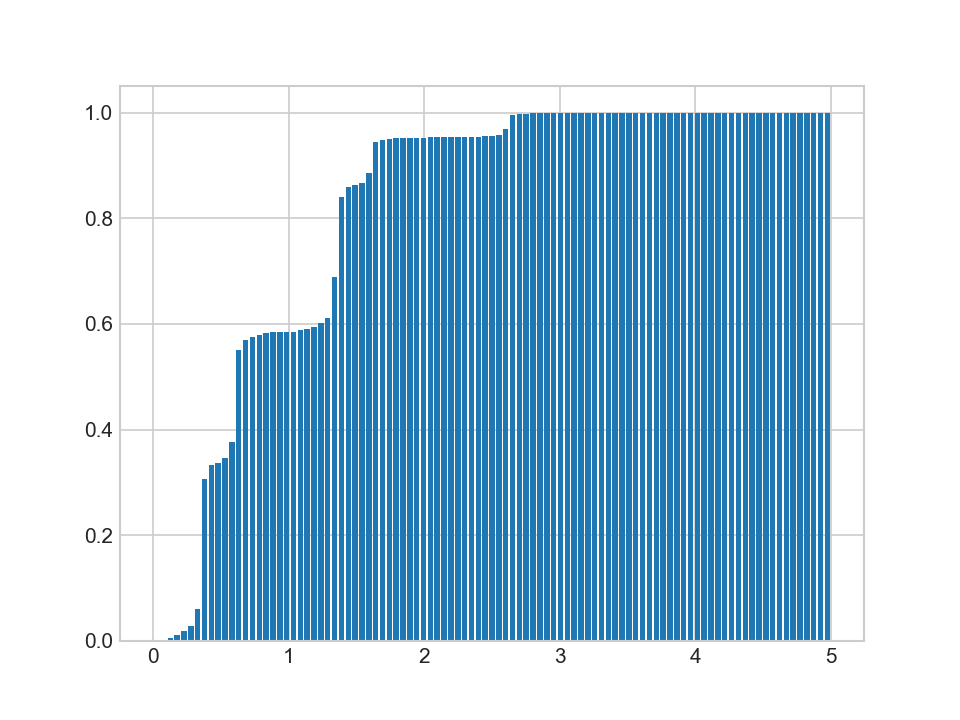

In [372]:
_, bins, _ = plt.hist(np.abs(y_test.values - xgb_knn_bsl_mu_test_preds), bins=np.linspace(0,5,100), cumulative=True,
         normed=True, rwidth=0.8)
plt.show()

# 3. Matrix Factorization Techniques

### 3.1 SVD -  MF algorithm with user item interactions

- __ Predicted Rating : __
    - 
    - $ \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $


- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [77]:
from surprise import SVD

In [78]:
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)

In [79]:
#train the model with trainset
start = datetime.now()
svd.fit(trainset =  trainset)
print(datetime.now() - start)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
0:00:07.827053


- __Evaluate the model with the trainset__

In [80]:
# get the predicted ratings for the trainset
svd_train_preds = svd.test(trainset.build_testset())

# get rmse and mape
svd_train_rmse, svd_train_mape = get_errors(svd_train_preds, print_them=True)


RMSE : 0.6523640307015464

MAPE : 19.35960301225469


In [81]:
models_evaluation_train['svd'] = {'rmse': svd_train_rmse,
                                  'mape': svd_train_mape}
_, svd_train_pred_ratings = get_ratings(svd_train_preds)
models_evaluation_train['svd']['predictions'] = svd_train_pred_ratings

models_evaluation_train['svd']

{'mape': 19.35960301225469,
 'predictions': array([3.52968404, 3.85335189, 3.69925493, ..., 4.11337679, 4.28847163,
        3.8911823 ]),
 'rmse': 0.6523640307015464}

- __Evaluating with test data__ 

In [82]:
svd_test_preds = svd.test(testset)

# get the rating from the prediction classes
svd_test_actual_ratings, svd_test_pred_ratings = get_ratings(svd_test_preds)

# calculate the rmse and mape
svd_test_rmse, svd_test_mape = get_errors(svd_test_preds, print_them=True)


RMSE : 1.2363770938140637

MAPE : 36.77836270611353


In [83]:
# store them in dictionary
models_evaluation_test['svd'] = {'rmse': svd_test_rmse, 
                                 'mape' : svd_test_mape}
models_evaluation_test['svd']['predictions'] = svd_test_pred_ratings

models_evaluation_test['svd']

{'mape': 36.77836270611353,
 'predictions': array([3.90535543, 3.29119792, 3.3840873 , ..., 3.37341526, 3.29107552,
        3.30847182]),
 'rmse': 1.2363770938140637}

In [84]:
print_error_dists(np.abs(svd_test_actual_ratings - svd_test_pred_ratings))

No. of predicted ratings with error between 0 and 1(inclusive) : 4498
No. of predicted ratings with error between 1 and 2(inclusive) : 2940
No. of predicted ratings with error between 2 and 3(inclusive) : 672
No. of predicted ratings with error between 3 and 4(inclusive) : 97
No. of predicted ratings with error > 4 : 0


### 3.2 SVD -  with Implicit feedback from user ( user rated movies )

- __ Predicted Rating : __
    - 
    - $ \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + y_j^2\right) $

In [85]:
from surprise import SVDpp

In [86]:
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)

In [87]:
#train the model with trainset
start = datetime.now()
svdpp.fit(trainset =  trainset)
print(datetime.now() - start)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
0:02:07.686967


- __Evaluate the model with the trainset__

In [89]:
# get the predicted ratings for the trainset
svdpp_train_preds = svdpp.test(trainset.build_testset())

# get rmse and mape
svdpp_train_rmse, svdpp_train_mape = get_errors(svdpp_train_preds, print_them=True)


RMSE : 0.6079436835198637

MAPE : 17.591518882877512


In [90]:
models_evaluation_train['svdpp'] = {'rmse': svdpp_train_rmse,
                                  'mape': svdpp_train_mape}
_, svdpp_train_pred_ratings = get_ratings(svdpp_train_preds)
models_evaluation_train['svdpp']['predictions'] = svdpp_train_pred_ratings

models_evaluation_train['svdpp']

{'mape': 17.591518882877512,
 'predictions': array([3.35122635, 4.26572895, 3.94832475, ..., 4.15486566, 4.54392303,
        3.98017486]),
 'rmse': 0.6079436835198637}

- __Evaluating with test data__ 

In [91]:
svdpp_test_preds = svdpp.test(testset)

# get the rating from the prediction classes
svdpp_test_actual_ratings, svdpp_test_pred_ratings = get_ratings(svdpp_test_preds)

# calculate the rmse and mape
svdpp_test_rmse, svdpp_test_mape = get_errors(svdpp_test_preds, print_them=True)


RMSE : 1.2475081306270126

MAPE : 36.6724863476801


In [92]:
# store them in dictionary
models_evaluation_test['svdpp'] = {'rmse': svdpp_test_rmse, 
                                 'mape' : svdpp_test_mape}
models_evaluation_test['svdpp']['predictions'] = svdpp_test_pred_ratings

models_evaluation_test['svdpp']

{'mape': 36.6724863476801,
 'predictions': array([3.8624555 , 3.21491122, 3.20947053, ..., 3.18721167, 3.31064836,
        3.27990616]),
 'rmse': 1.2475081306270126}

In [258]:
print_error_dists(np.abs(svdpp_test_actual_ratings - svdpp_test_pred_ratings))

No. of predicted ratings with error between 0 and 1(inclusive) : 4448
No. of predicted ratings with error between 1 and 2(inclusive) : 2935
No. of predicted ratings with error between 2 and 3(inclusive) : 754
No. of predicted ratings with error between 3 and 4(inclusive) : 70
No. of predicted ratings with error > 4 : 0


## 4 XGBoost with svd and svdpp 

### Preparing Train data

In [261]:
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0,3.000000,3.055318
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0,4.049548,4.193583


In [262]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0,3.000000,3.055318,3.529684,3.351226
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0,4.049548,4.193583,3.853352,4.265729


###  Preparing Test data 

In [263]:
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0,1.861352,3.712417
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0,3.239671,3.239671


In [265]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m,svd,svdpp
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0,1.861352,3.712417,3.905355,3.862455
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0,3.239671,3.239671,3.291198,3.214911


### Running the XGBoost (with just svd)

In [266]:
xgb_svd = xgb.XGBRegressor(n_jobs=10, random_state=15)

In [267]:
x_train = reg_train.drop(['user', 'movie', 'rating', 'svdpp'], axis=1)
y_train = reg_train['rating']

In [270]:
start = datetime.now()
xgb_svd.fit(x_train, y_train)
print(datetime.now()- start)

0:00:01.390474


<IPython.core.display.Javascript object>


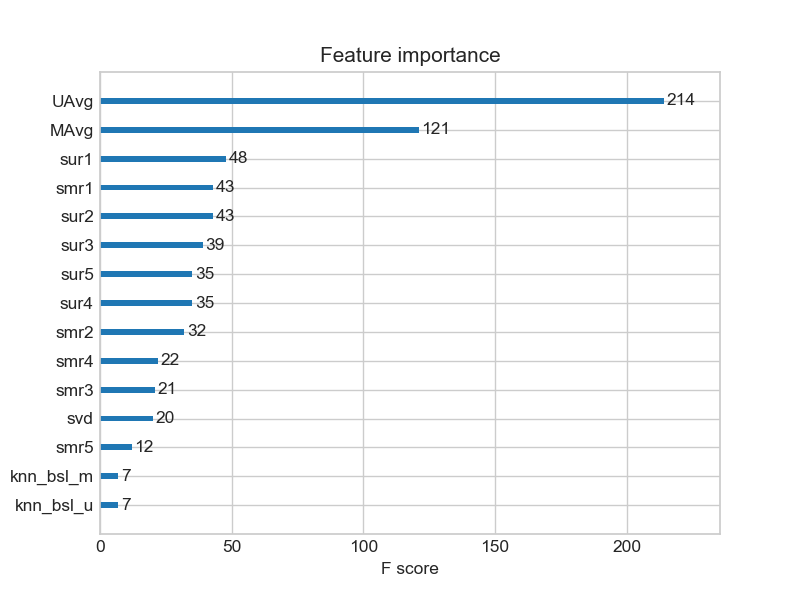

In [271]:
xgb.plot_importance(xgb_svd)
plt.show()

 #### 2.3.3.1 Evaluating with Train Data

In [272]:
start = datetime.now()
xgb_svd_train_preds = xgb_svd.predict(x_train)
print(datetime.now()- start)

0:00:00.069017


In [273]:
# find the error metrics and store them in dictionary..
xgb_svd_train_rmse, xgb_svd_train_mape = get_error_metrics(y_true = y_train.values, y_pred = xgb_svd_train_preds)

In [274]:
print_error_dists(np.abs(y_train.values -  xgb_svd_train_preds))

No. of predicted ratings with error between 0 and 1(inclusive) : 98323
No. of predicted ratings with error between 1 and 2(inclusive) : 24772
No. of predicted ratings with error between 2 and 3(inclusive) : 2918
No. of predicted ratings with error between 3 and 4(inclusive) : 215
No. of predicted ratings with error > 4 : 0


<IPython.core.display.Javascript object>


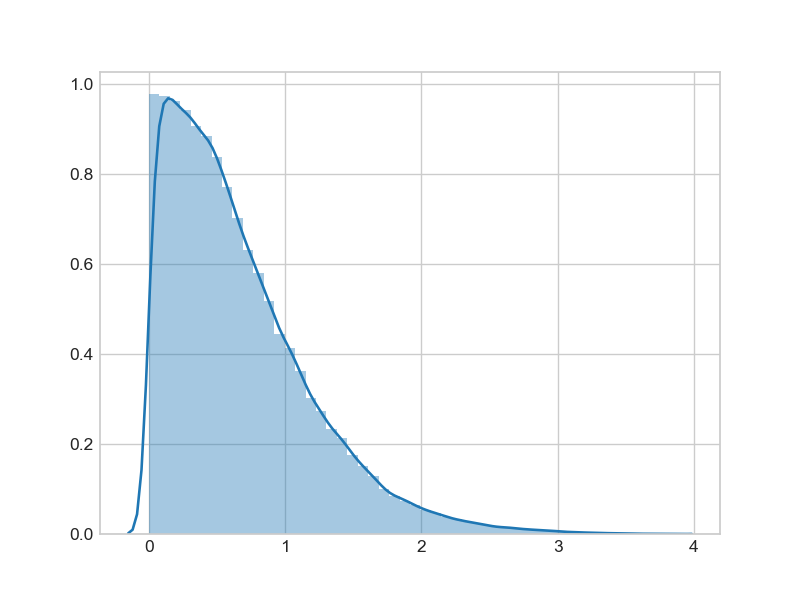

In [275]:
sns.distplot(np.abs(y_train.values -  xgb_svd_train_preds))
plt.show()

In [276]:
# adding it's metrics to models dictionary 
#####################################################################
models_evaluation_train['xgb_svd'] = {'rmse' : xgb_svd_train_rmse,
                                          'mape' : xgb_svd_train_mape}
models_evaluation_train['xgb_svd']['predictions'] = xgb_svd_train_preds


models_evaluation_train['xgb_svd']

{'mape': 25.044214894335177,
 'predictions': array([2.359809 , 1.7107487, 3.4074478, ..., 3.0371664, 3.005474 ,
        3.8204186], dtype=float32),
 'rmse': 0.8472645948537134}

 #### 2.3.3.2 Evaluating with Test Data

In [279]:
x_test = reg_test_df.drop(['user', 'movie', 'rating', 'svdpp'], axis=1)
y_test = reg_test_df['rating']

In [280]:
# get the predicted ratings for this test data
start = datetime.now()
xgb_svd_test_predictions = xgb_svd.predict(x_test)
print(datetime.now() - start)

0:00:00.009979


In [281]:
print_error_dists(np.abs(y_test.values - xgb_svd_test_predictions))

No. of predicted ratings with error between 0 and 1(inclusive) : 4906
No. of predicted ratings with error between 1 and 2(inclusive) : 2611
No. of predicted ratings with error between 2 and 3(inclusive) : 603
No. of predicted ratings with error between 3 and 4(inclusive) : 87
No. of predicted ratings with error > 4 : 1


<IPython.core.display.Javascript object>


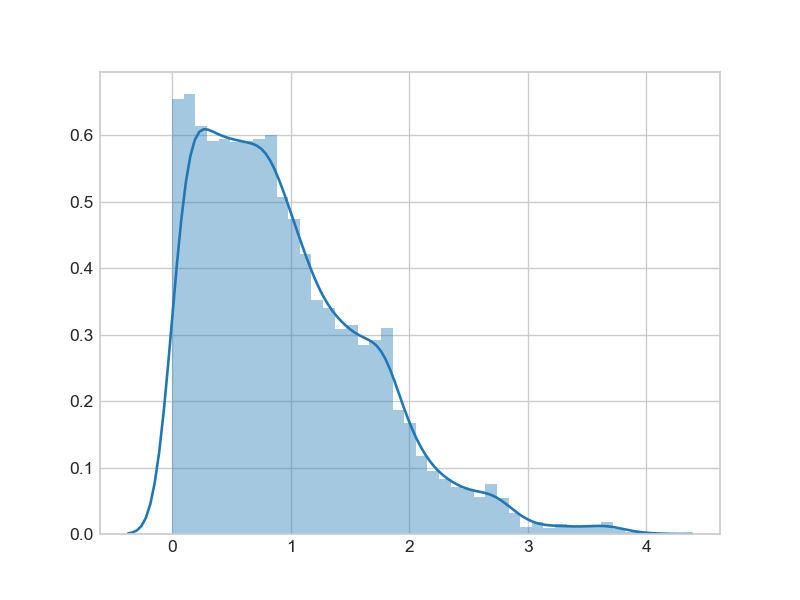

In [282]:
sns.distplot(np.abs(y_test.values-xgb_svd_test_predictions))
plt.show()

In [283]:
xgb_svd_test_rmse, xgb_svd_test_mape = get_error_metrics(y_test.values, xgb_svd_test_predictions) 

In [284]:
# store them
################################
models_evaluation_test['xgb_svd'] = {'rmse' : xgb_svd_test_rmse,
                                         'mape' : xgb_svd_test_mape}
models_evaluation_test['xgb_svd']['predictions'] = xgb_svd_test_predictions

models_evaluation_test['xgb_svd']

{'mape': 35.07667855314228,
 'predictions': array([3.9302764, 2.4213667, 3.0477576, ..., 3.3985217, 3.2339442,
        3.0097656], dtype=float32),
 'rmse': 1.1900941585939357}

### Running the XGBoost ( with svdpp)

In [285]:
xgb_svdpp = xgb.XGBRegressor(n_jobs=10, random_state=15)

In [286]:
x_train = reg_train.drop(['user', 'movie', 'rating', 'svd'], axis=1)
y_train = reg_train['rating']

In [287]:
start = datetime.now()
xgb_svdpp.fit(x_train, y_train)
print(datetime.now()- start)

0:00:01.440294


<IPython.core.display.Javascript object>


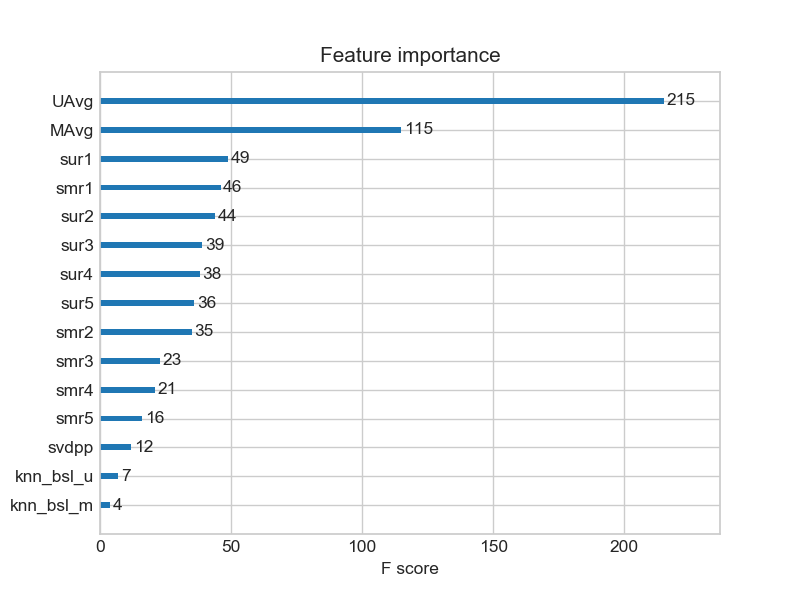

In [288]:
xgb.plot_importance(xgb_svdpp)
plt.show()

 #### 2.3.3.1 Evaluating with Train Data

In [289]:
start = datetime.now()
xgb_svdpp_train_preds = xgb_svdpp.predict(x_train)
print(datetime.now()- start)

0:00:00.082019


In [290]:
# find the error metrics and store them in dictionary..
xgb_svdpp_train_rmse, xgb_svdpp_train_mape = get_error_metrics(y_true = y_train.values, y_pred = xgb_svdpp_train_preds)

In [291]:
print_error_dists(np.abs(y_train.values -  xgb_svdpp_train_preds))

No. of predicted ratings with error between 0 and 1(inclusive) : 98294
No. of predicted ratings with error between 1 and 2(inclusive) : 24804
No. of predicted ratings with error between 2 and 3(inclusive) : 2918
No. of predicted ratings with error between 3 and 4(inclusive) : 212
No. of predicted ratings with error > 4 : 0


<IPython.core.display.Javascript object>


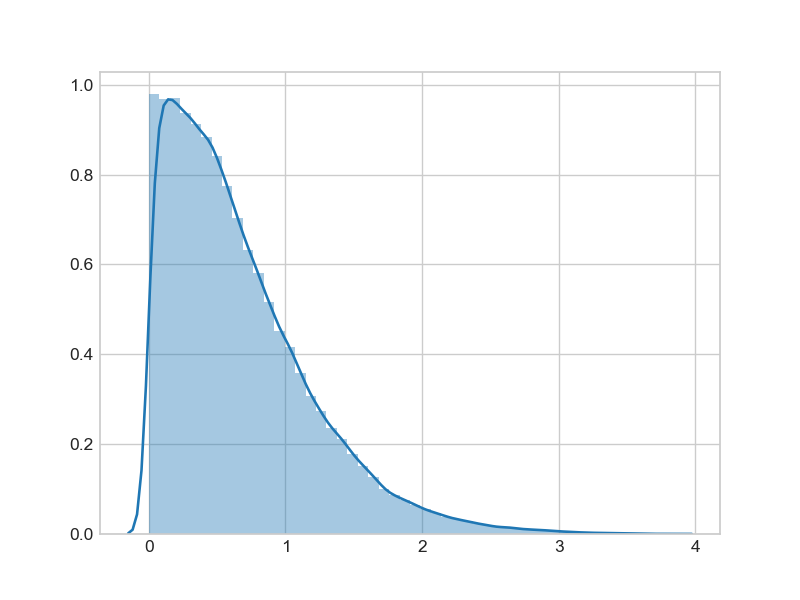

In [292]:
sns.distplot(np.abs(y_train.values -  xgb_svdpp_train_preds))
plt.show()

In [293]:
# adding it's metrics to models dictionary 
#####################################################################
models_evaluation_train['xgb_svdpp'] = {'rmse' : xgb_svdpp_train_rmse,
                                          'mape' : xgb_svdpp_train_mape}
models_evaluation_train['xgb_svdpp']['predictions'] = xgb_svdpp_train_preds


models_evaluation_train['xgb_svdpp']

{'mape': 25.04402234509722,
 'predictions': array([2.351577 , 1.7464645, 3.3994887, ..., 3.0383768, 3.0446613,
        3.8028624], dtype=float32),
 'rmse': 0.8473333755757457}

 #### 2.3.3.2 Evaluating with Test Data

In [294]:
x_test = reg_test_df.drop(['user', 'movie', 'rating', 'svd'], axis=1)
y_test = reg_test_df['rating']

In [295]:
# get the predicted ratings for this test data
start = datetime.now()
xgb_svdpp_test_predictions = xgb_svdpp.predict(x_test)
print(datetime.now() - start)

0:00:00.005000


In [296]:
print_error_dists(np.abs(y_test.values - xgb_svdpp_test_predictions))

No. of predicted ratings with error between 0 and 1(inclusive) : 4906
No. of predicted ratings with error between 1 and 2(inclusive) : 2613
No. of predicted ratings with error between 2 and 3(inclusive) : 599
No. of predicted ratings with error between 3 and 4(inclusive) : 90
No. of predicted ratings with error > 4 : 0


<IPython.core.display.Javascript object>


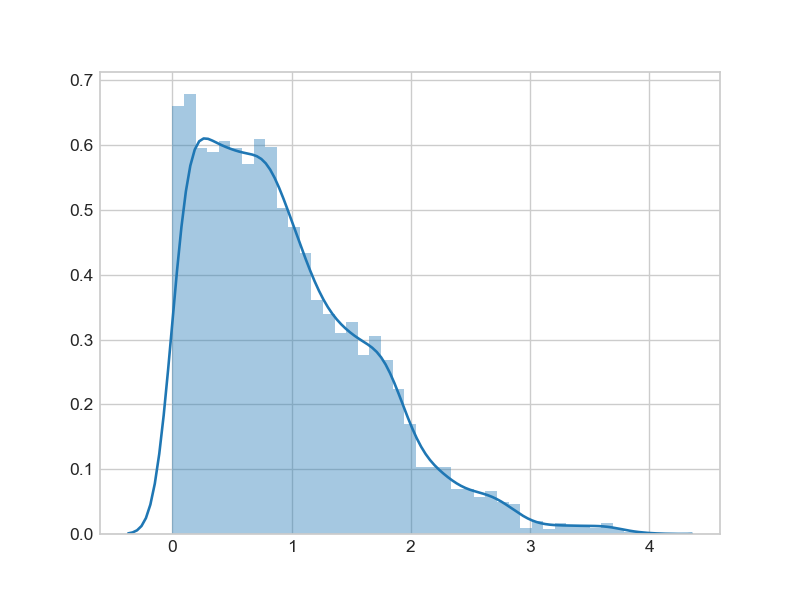

In [297]:
sns.distplot(np.abs(y_test.values-xgb_svdpp_test_predictions))
plt.show()

In [298]:
xgb_svdpp_test_rmse, xgb_svdpp_test_mape = get_error_metrics(y_test.values, xgb_svdpp_test_predictions) 

In [299]:
# store them
################################
models_evaluation_test['xgb_svdpp'] = {'rmse' : xgb_svdpp_test_rmse,
                                         'mape' : xgb_svdpp_test_mape}
models_evaluation_test['xgb_svdpp']['predictions'] = xgb_svdpp_test_predictions

models_evaluation_test['xgb_svdpp']

{'mape': 35.0049845401326,
 'predictions': array([3.8332949, 2.4073033, 2.9797342, ..., 3.4046187, 3.2133107,
        3.0177183], dtype=float32),
 'rmse': 1.1893382263521337}

### XGBoost ( only with knn_bsl_m, knn_bsl_u, SVD and SVDPP predictions )

In [304]:
# preparing train data
x_train = reg_train[['knn_bsl_u','knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# preparing test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

In [305]:
xgb_svd_svdpp = xgb.XGBRegressor(n_jobs=10, random_state=15)

In [307]:
xgb_svd_svdpp.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=10, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

<IPython.core.display.Javascript object>


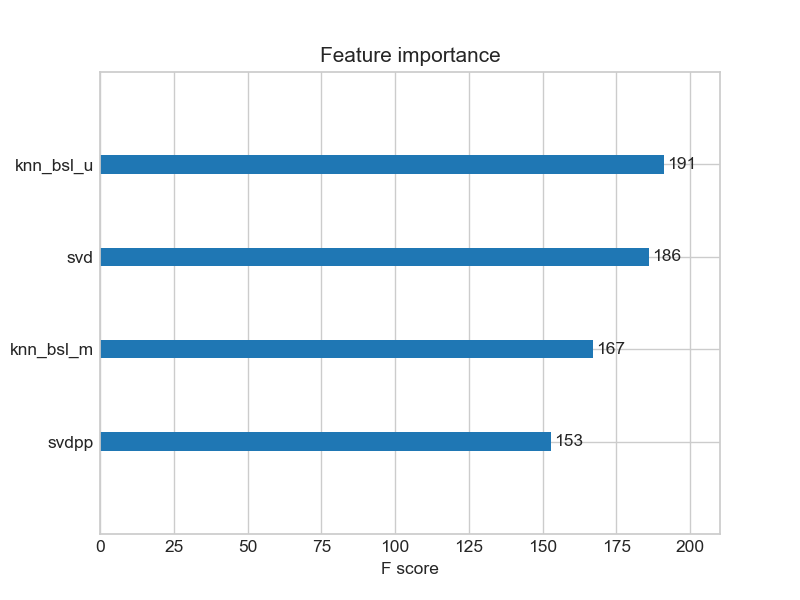

In [308]:
xgb.plot_importance(xgb_svd_svdpp)
plt.show()

- __Evaluating the model with the train data__

In [309]:
xgb_svd_svdpp_train_preds = xgb_svd_svdpp.predict(x_train)

# get the errors (rmse and mape)
xgb_svd_svdpp_train_rmse, xgb_svd_svdpp_train_mape = get_error_metrics(y_true=y_train.values, 
                                                                        y_pred = xgb_svd_svdpp_train_preds)

In [310]:
print_error_dists(np.abs(y_train.values - xgb_svd_svdpp_train_preds))

No. of predicted ratings with error between 0 and 1(inclusive) : 79061
No. of predicted ratings with error between 1 and 2(inclusive) : 41401
No. of predicted ratings with error between 2 and 3(inclusive) : 5766
No. of predicted ratings with error between 3 and 4(inclusive) : 0
No. of predicted ratings with error > 4 : 0


<IPython.core.display.Javascript object>


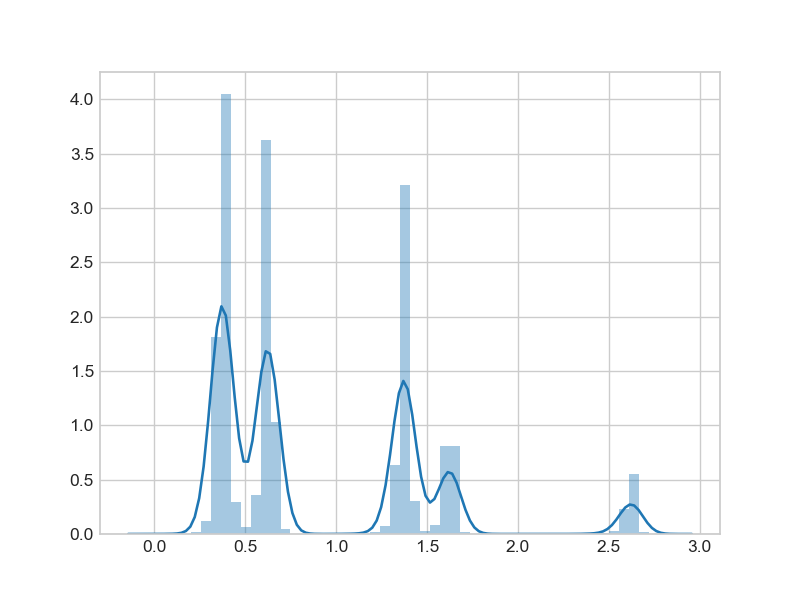

In [311]:
sns.distplot(np.abs(y_train.values - xgb_svd_svdpp_train_preds))
plt.show()

In [312]:
# store them in models dictionary..
models_evaluation_train['xgb_svd_svdpp'] = {'rmse' : xgb_svd_svdpp_train_rmse,
                                             'mape' : xgb_svd_svdpp_train_mape}
models_evaluation_train['xgb_svd_svdpp']['predictions'] = xgb_svd_svdpp_train_preds

models_evaluation_train['xgb_svd_svdpp']

{'mape': 35.10431211320362,
 'predictions': array([3.6135259, 3.640571 , 3.6309824, ..., 3.6073282, 3.575307 ,
        3.628288 ], dtype=float32),
 'rmse': 1.0760427305617022}

- __Evaluating the model with test data__ 

In [313]:
# get the predictions for the test data
xgb_svd_svdpp_test_preds = xgb_svd_svdpp.predict(x_test)

print_error_dists(np.abs(y_test.values - xgb_svd_svdpp_test_preds))

No. of predicted ratings with error between 0 and 1(inclusive) : 4813
No. of predicted ratings with error between 1 and 2(inclusive) : 3015
No. of predicted ratings with error between 2 and 3(inclusive) : 380
No. of predicted ratings with error between 3 and 4(inclusive) : 0
No. of predicted ratings with error > 4 : 0


In [314]:
# get error metrics and store them in models dictionary
xgb_svd_svdpp_test_rmse, xgb_svd_svdpp_test_mape = get_error_metrics(y_test.values, xgb_svd_svdpp_test_preds)

# store them in models dictionary
models_evaluation_test['xgb_svd_svdpp'] = {'rmse': xgb_svd_svdpp_test_rmse, 
                                            'mape': xgb_svd_svdpp_test_mape}
models_evaluation_test['xgb_svd_svdpp']['predictions'] = xgb_svd_svdpp_test_preds

models_evaluation_test['xgb_svd_svdpp']

{'mape': 35.04458532139145,
 'predictions': array([3.6846292, 3.6431882, 3.6431882, ..., 3.6431882, 3.6431882,
        3.6431882], dtype=float32),
 'rmse': 1.10309969628529}

###  Linear Regression

In [366]:
x_train.head(2)

,knn_bsl_u,knn_bsl_m,svd,svdpp
0,3.000000,3.055318,3.529684,3.351226
1,4.049548,4.193583,3.853352,4.265729


In [367]:
y_train.head(2)

0    3.0
1    1.0
Name: rating, dtype: float64

In [369]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression(fit_intercept=True, normalize=True, n_jobs = 10)
lr_reg.fit(x_train, y_train)

print("--TRAIN DATA---")
print('-'*20)

lr_reg_train_preds = lr_reg.predict(x_train)
lr_reg_train_rmse, lr_reg_train_mape = get_error_metrics(y_train, lr_reg_train_preds)
print('rmse : {} \nmape : {}'.format(lr_reg_train_rmse, lr_reg_train_mape))

print("--TEST DATA---")
print('-'*20)

lr_reg_test_preds = lr_reg.predict(x_test)
lr_reg_test_rmse, lr_reg_test_mape = get_error_metrics(y_test, lr_reg_test_preds)
print('rmse : {} \nmape : {}'.format(lr_reg_test_rmse, lr_reg_test_mape))

--TRAIN DATA---
--------------------
rmse : 1.0791105328599013 
mape : 35.21555821510084
--TEST DATA---
--------------------
rmse : 1.103075592942197 
mape : 35.0753132901451


In [370]:
models.loc['rmse']

bsl_algo          0.174485
first_xgb          1.19016
knn_bsl_m         0.236401
knn_bsl_u         0.286293
svd               0.227125
svdpp             0.262077
xgb_bsl            1.18965
xgb_knn_bsl        1.19085
xgb_knn_bsl_mu     1.10552
xgb_svd            1.19009
xgb_svd_svdpp       1.1031
xgb_svdpp          1.18934
Name: rmse, dtype: object

In [94]:
models = pd.DataFrame(models_evaluation_test)

In [95]:
models

,bsl_algo,knn_bsl_m,knn_bsl_u,svd,svdpp
mape,35.805,38.3812,38.3102,36.7784,36.6725
predictions,"[3.948776296894135, 3.542483581752569, 3.56137...","[3.71241675632085, 3.2396708117633644, 3.34715...","[1.86135189886117, 3.2396708117633644, 3.34715...","[3.9053554299989575, 3.2911979190060316, 3.384...","[3.8624554992219693, 3.214911223953335, 3.2094..."
rmse,1.16748,1.33046,1.32377,1.23638,1.24751


In [370]:
models.loc['rmse']

bsl_algo          0.174485
first_xgb          1.19016
knn_bsl_m         0.236401
knn_bsl_u         0.286293
svd               0.227125
svdpp             0.262077
xgb_bsl            1.18965
xgb_knn_bsl        1.19085
xgb_knn_bsl_mu     1.10552
xgb_svd            1.19009
xgb_svd_svdpp       1.1031
xgb_svdpp          1.18934
Name: rmse, dtype: object

In [319]:
models = pd.DataFrame(models_evaluation_test)

In [320]:
models

,bsl_algo,first_xgb,knn_bsl_m,knn_bsl_u,svd,svdpp,xgb_bsl,xgb_knn_bsl,xgb_knn_bsl_mu,xgb_svd,xgb_svd_svdpp,xgb_svdpp
mape,35.805,35.0346,38.3812,38.3102,36.7784,36.6725,35.0503,35.0336,35.0675,35.0767,35.0446,35.005
predictions,"[3.948776296894135, 3.542483581752569, 3.56137...","[3.854013, 2.3819778, 3.0049725, 3.415036, 3.7...","[3.71241675632085, 3.2396708117633644, 3.34715...","[1.86135189886117, 3.2396708117633644, 3.34715...","[3.9053554299989575, 3.2911979190060316, 3.384...","[3.8624554992219693, 3.214911223953335, 3.2094...","[3.8989341, 2.40227, 3.0303586, 3.317571, 3.77...","[3.8228877, 2.3294072, 2.9366271, 3.3515148, 3...","[3.4530203, 3.6423204, 3.6423204, 3.4945145, 3...","[3.9302764, 2.4213667, 3.0477576, 3.4541488, 3...","[3.6846292, 3.6431882, 3.6431882, 3.7681634, 3...","[3.8332949, 2.4073033, 2.9797342, 3.5056124, 3..."
rmse,0.174485,1.19016,0.236401,0.286293,0.227125,0.262077,1.18965,1.19085,1.10552,1.19009,1.1031,1.18934


In [321]:
models.loc['rmse']

bsl_algo          0.174485
first_xgb          1.19016
knn_bsl_m         0.236401
knn_bsl_u         0.286293
svd               0.227125
svdpp             0.262077
xgb_bsl            1.18965
xgb_knn_bsl        1.19085
xgb_knn_bsl_mu     1.10552
xgb_svd            1.19009
xgb_svd_svdpp       1.1031
xgb_svdpp          1.18934
Name: rmse, dtype: object

In [365]:
models.loc['mape']

bsl_algo           35.805
first_xgb         35.0346
knn_bsl_m         38.3812
knn_bsl_u         38.3102
svd               36.7784
svdpp             36.6725
xgb_bsl           35.0503
xgb_knn_bsl       35.0336
xgb_knn_bsl_mu    35.0675
xgb_svd           35.0767
xgb_svd_svdpp     35.0446
xgb_svdpp          35.005
Name: mape, dtype: object